## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1
def build_mlp(input_shape, num_outputs = 10, num_neurons = [512,256,128],L1_ratio = 0.001):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, neuron in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units = neuron,
                                    activation = "relu",
                                    name = f"Hidden_layer{i+1}",
                                    kernel_regularizer = l1(L1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units = neuron,
                                    activation = "relu",
                                    name = f"Hidden_layer{i+1}",
                                    kernel_regularizer = l1(L1_ratio))(x)

    out = keras.layers.Dense(units = num_outputs, 
                                activation = "softmax",
                                name = "Output_layer",
                                kernel_regularizer = l1(L1_ratio))(x)
                                
    model = keras.models.Model(inputs = input_layer, outputs = out)
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in L1_EXP:
    keras.backend.clear_session()
    model = build_mlp(x_train.shape[1:],L1_ratio=i)
    model.summary()
    SGD = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics=["accuracy"], optimizer=SGD)
    model.fit(x_train,y_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test,y_test))
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]


    L1_tag = f"L1_ratio:{i}"
    results[L1_tag] = {"train_loss":train_loss,
                        "valid_loss":valid_loss,
                        "train_acc":train_acc,
                        "valid_acc":valid_acc}

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 Hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 Hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 Hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


c:\Users\wei-jyun\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 5s 22ms/step - loss: 200.1789 - accuracy: 0.2379 - val_loss: 42.2126 - val_accuracy: 0.2543
Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 19.9421 - accuracy: 0.1180 - val_loss: 7.8926 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 5s 25ms/step - loss: 4.5522 - accuracy: 0.1000 - val_loss: 2.9426 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 2.6793 - accuracy: 0.1000 - val_loss: 2.5688 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 5s 26ms/step - loss: 2.5156 - accuracy: 0.1000 - val_loss: 2.4772 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 6s 29ms/step - loss: 2.4663 - accuracy: 0.0969 - val_loss: 2.4629 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 6s 32ms/step - loss: 2.4627 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.

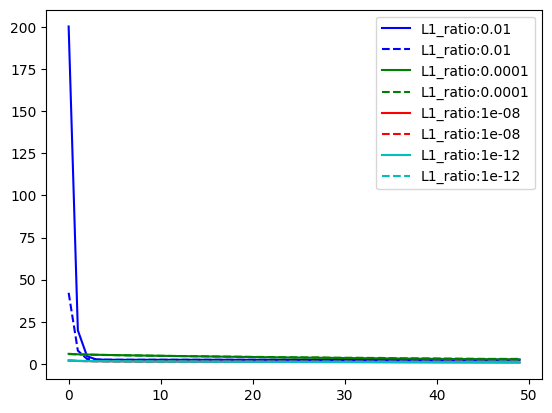

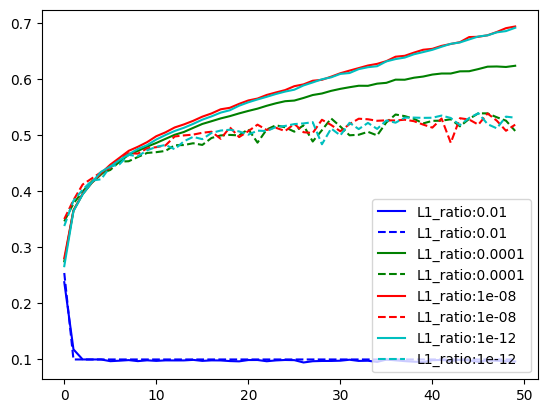

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
col_bar = ["b","g","r","c"]
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_loss"])), results[cond]["train_loss"], "-",label = cond, c = col_bar[i])
    plt.plot(range(len(results[cond]["valid_loss"])), results[cond]["valid_loss"], "--",label = cond, c = col_bar[i])
plt.legend()
plt.show()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_acc"])), results[cond]["train_acc"], "-",label = cond, c = col_bar[i])
    plt.plot(range(len(results[cond]["valid_acc"])), results[cond]["valid_acc"], "--",label = cond, c = col_bar[i])
plt.legend()
plt.show()